# Fake Reviews Detection - Complete Analysis

This notebook provides a comprehensive analysis for detecting fake reviews using various machine learning algorithms. We'll use text preprocessing, feature extraction, and multiple classification models to identify fake reviews.

## Table of Contents
1. **Import Libraries and Setup**
2. **Data Loading and Exploration**
3. **Data Preprocessing and Cleaning**
4. **Exploratory Data Analysis (EDA)**
5. **Text Processing and Feature Engineering**
6. **Model Training and Evaluation**
7. **Model Comparison and Results**
8. **Pipeline Approach with TF-IDF**
9. **Model Saving and Conclusion**
10. **Final Results Summary**

# 1. Import Libraries and Setup
Import all necessary libraries for data processing, visualization, and machine learning.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle
import os
from collections import Counter

# Machine Learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Download required NLTK data
nltk.download('stopwords', quiet=True)

# Settings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Set style for better visualization
sns.set_style("whitegrid")
plt.style.use('default')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


# 2. Data Loading and Exploration
Load the preprocessed dataset and perform initial exploration.

In [2]:
# Load the dataset
dataset_path = "Preprocessed Fake Reviews Detection Dataset.csv"
df = pd.read_csv(dataset_path)

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset loaded successfully!
Dataset shape: (40432, 5)

First 5 rows:


,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i
4,4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month


In [3]:
# Basic information about the dataset
print("Dataset Information:")
print("=" * 50)
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  40432 non-null  int64  
 1   category    40432 non-null  object 
 2   rating      40432 non-null  float64
 3   label       40432 non-null  object 
 4   text_       40431 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [4]:
# Check for missing values and duplicates
print("Missing Values Analysis:")
print("=" * 30)
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")

Missing Values Analysis:
Missing values per column:
Unnamed: 0    0
category      0
rating        0
label         0
text_         1
dtype: int64

Total missing values: 1
Duplicate rows: 0


# 3. Data Preprocessing and Cleaning
Clean the data and prepare it for analysis.

In [5]:
# Clean the data
# Remove unnamed columns if exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("✓ Removed 'Unnamed: 0' column")

# Remove any remaining missing values
initial_shape = df.shape
df.dropna(inplace=True)
print(f"✓ Removed {initial_shape[0] - df.shape[0]} rows with missing values")

# Add text length feature for analysis
df['text_length'] = df['text_'].apply(len)
print("✓ Added text_length feature")

print("\nData cleaning completed!")
print(f"Final dataset shape: {df.shape}")
df.head()

✓ Removed 'Unnamed: 0' column
✓ Removed 1 rows with missing values
✓ Added text_length feature

Data cleaning completed!
Final dataset shape: (40431, 5)
✓ Added text_length feature

Data cleaning completed!
Final dataset shape: (40431, 5)


,category,rating,label,text_,text_length
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort i love veri pretti,48
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin i 've mine coupl year,46
2,Home_and_Kitchen_5,5.0,CG,thi pillow save back i love look feel pillow,44
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price i,37
4,Home_and_Kitchen_5,5.0,CG,veri nice set good qualiti we set two month,43


In [6]:
# Display basic statistics
print("Dataset Statistics:")
print("=" * 30)
df.describe(include='all').T

Dataset Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
category,40431,10,Kindle_Store_5,4730,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,40431.0,NaN,NaN,NaN,4.256585,1.144367,1.0,4.0,5.0,5.0,5.0
label,40431,2,OR,20216,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text_,40431,40387,my dog love kept occupi long time she chase,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text_length,40431.0,NaN,NaN,NaN,205.767109,219.422327,8.0,64.0,116.0,253.0,2232.0


# 4. Exploratory Data Analysis (EDA)
Analyze the distribution of labels and text characteristics.

In [7]:
# Analyze label distribution
print("Label Distribution:")
print("=" * 20)
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nLabel proportions:")
print(df['label'].value_counts(normalize=True).round(4))

Label Distribution:
label
OR    20216
CG    20215
Name: count, dtype: int64

Label proportions:
label
OR    0.5
CG    0.5
Name: proportion, dtype: float64


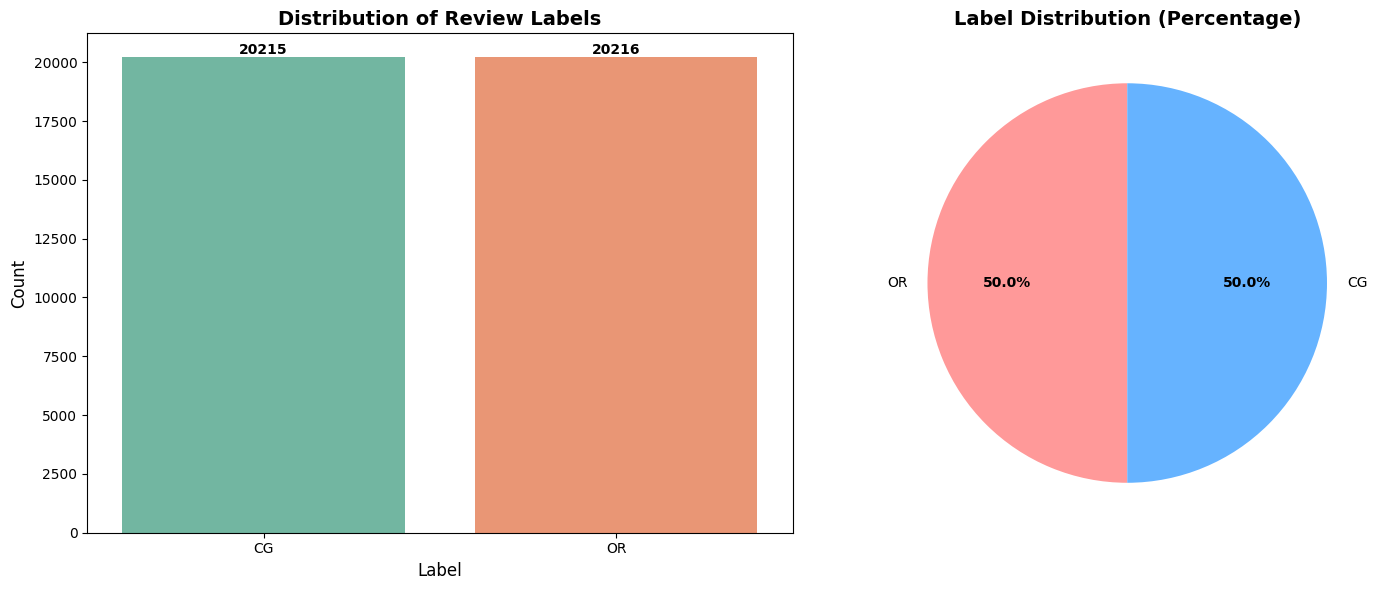

In [8]:
# Visualize label distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
sns.countplot(data=df, x='label', palette='Set2', ax=ax1)
ax1.set_title('Distribution of Review Labels', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Add count labels on bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#FF9999', '#66B3FF']
wedges, texts, autotexts = ax2.pie(label_counts.values, labels=label_counts.index, 
                                  colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Label Distribution (Percentage)', fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

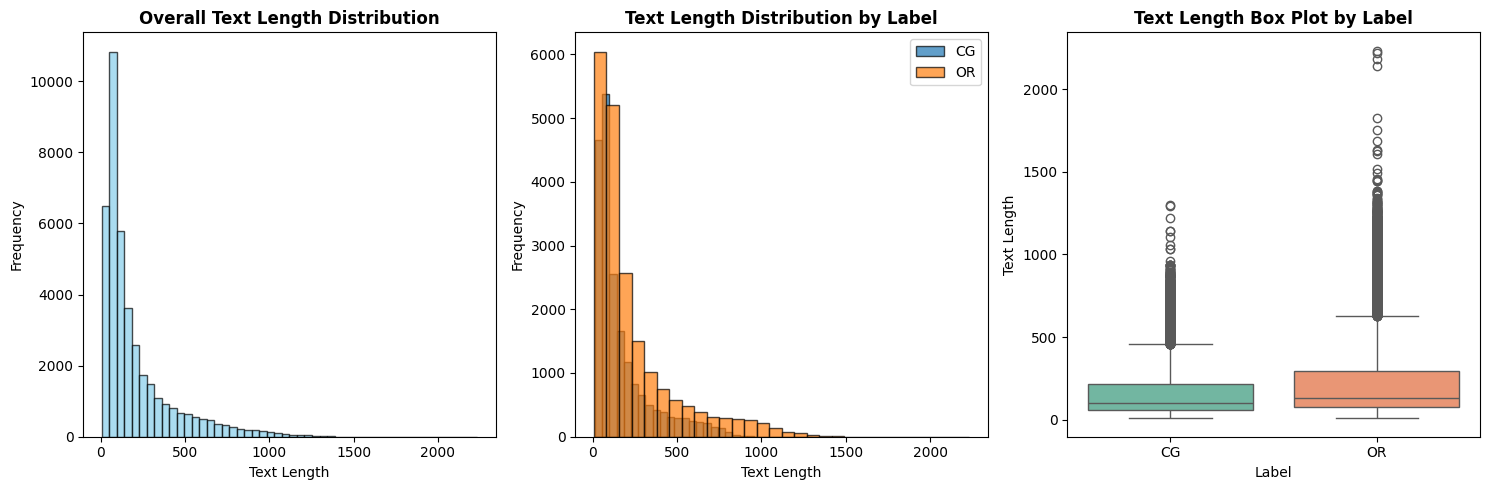

In [9]:
# Analyze text length distribution
plt.figure(figsize=(15, 5))

# Overall text length distribution
plt.subplot(1, 3, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Overall Text Length Distribution', fontweight='bold')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Text length by label
plt.subplot(1, 3, 2)
for label in df['label'].unique():
    subset = df[df['label'] == label]['text_length']
    plt.hist(subset, bins=30, alpha=0.7, label=f'{label}', edgecolor='black')
plt.title('Text Length Distribution by Label', fontweight='bold')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()

# Box plot for text length by label
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='label', y='text_length', palette='Set2')
plt.title('Text Length Box Plot by Label', fontweight='bold')
plt.xlabel('Label')
plt.ylabel('Text Length')

plt.tight_layout()
plt.show()

In [10]:
# Statistical summary by label
print("Text Length Statistics by Label:")
print("=" * 35)
text_stats = df.groupby('label')['text_length'].describe()
print(text_stats)

Text Length Statistics by Label:
         count        mean         std   min   25%    50%    75%     max
label                                                                   
CG     20215.0  173.639030  173.955252  13.0  57.0   99.0  217.0  1300.0
OR     20216.0  237.893599  252.920950   8.0  74.0  134.0  296.0  2232.0


# 5. Text Processing and Feature Engineering
Process the text data and create features for machine learning.

In [11]:
# Define text preprocessing function
def text_process(text):
    """
    Process text by:
    1. Removing punctuation
    2. Converting to lowercase
    3. Removing stopwords
    4. Tokenizing
    """
    # Remove punctuation and convert to lowercase
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc).lower()
    
    # Remove stopwords and tokenize
    return [word for word in nopunc.split() if word not in stopwords.words('english')]

# Test the function
sample_text = df['text_'].iloc[0]
print("Original text sample:")
print(sample_text[:200] + "...")
print("\nProcessed text sample:")
print(text_process(sample_text)[:20])

Original text sample:
love well made sturdi comfort i love veri pretti...

Processed text sample:
['love', 'well', 'made', 'sturdi', 'comfort', 'love', 'veri', 'pretti']


In [12]:
# Alternative preprocessing using NLTK stemming (similar to spam detection approach)
ps = PorterStemmer()
corpus = []

# Get stopwords but keep 'not' as it's important for sentiment
all_stop_words = set(stopwords.words('english'))
all_stop_words.remove('not')

print("Processing text data...")
for i in range(len(df)):
    # Convert to lowercase, remove punctuation, and split
    text = df['text_'].iloc[i].lower().translate(str.maketrans('', '', string.punctuation)).split()
    
    # Apply stemming and remove stopwords
    text = [ps.stem(word) for word in text if word not in all_stop_words]
    text = ' '.join(text)
    corpus.append(text)

print(f"Text processing completed for {len(corpus)} reviews!")

# Show example of processed text
print("\nExample of processed text:")
print("Original:", df['text_'].iloc[0][:100] + "...")
print("Processed:", corpus[0][:100] + "...")

Processing text data...


Text processing completed for 40431 reviews!

Example of processed text:
Original: love well made sturdi comfort i love veri pretti...
Processed: love well made sturdi comfort love veri pretti...


In [13]:
# Analyze most common words in the corpus
print("Most Common Words in Processed Corpus:")
print("=" * 40)
most_common = Counter(' '.join(corpus).split()).most_common(20)
for word, count in most_common:
    print(f"{word:15} : {count}")

Most Common Words in Processed Corpus:
love            : 19088
book            : 17351
great           : 16641
nt              : 15001
one             : 14633
good            : 14286
like            : 12755
use             : 12640
read            : 11578
thi             : 11518
would           : 10770
stori           : 10334
well            : 10308
work            : 8415
get             : 8374
littl           : 8150
charact         : 7158
recommend       : 6622
look            : 6557
time            : 6384


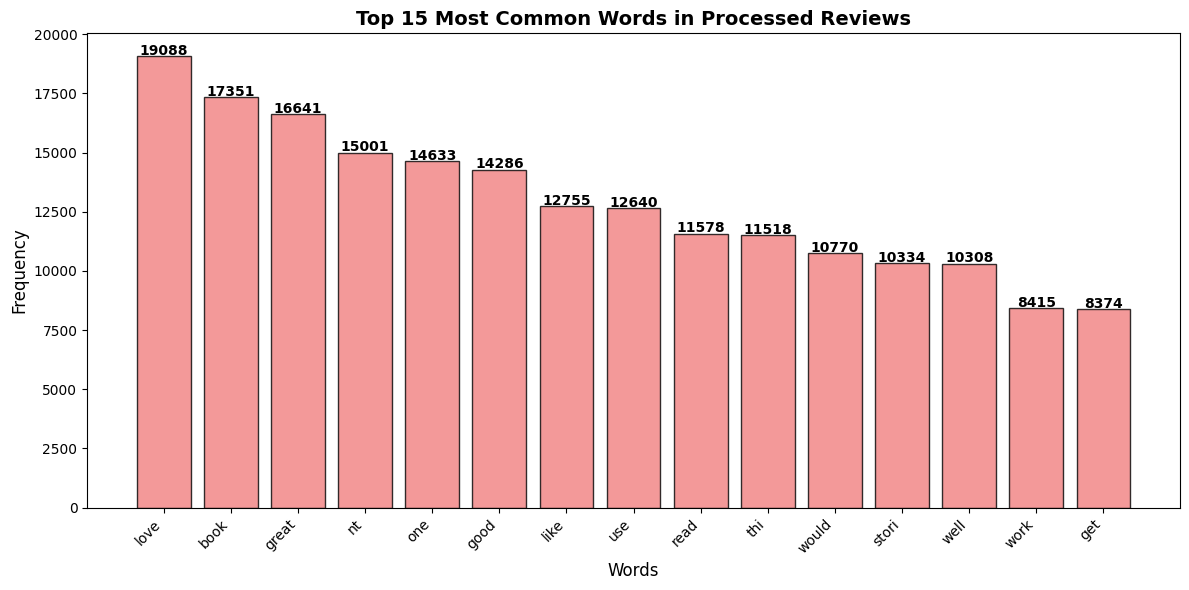

In [14]:
# Visualize most common words
words, counts = zip(*Counter(' '.join(corpus).split()).most_common(15))

plt.figure(figsize=(12, 6))
bars = plt.bar(words, counts, color='lightcoral', edgecolor='black', alpha=0.8)
plt.title('Top 15 Most Common Words in Processed Reviews', fontsize=14, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
             f'{int(bar.get_height())}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Model Training and Evaluation
Create and train multiple machine learning models for comparison.

In [15]:
# Create Bag of Words model
print("Creating Bag of Words features...")
cv = CountVectorizer(max_features=5000)  # Limit features for efficiency
X = cv.fit_transform(corpus).toarray()
y = df['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Feature matrix sparsity: {np.round((np.count_nonzero(X) / X.size) * 100, 2)}%")

Creating Bag of Words features...


Feature matrix shape: (40431, 5000)
Target variable shape: (40431,)
Feature matrix sparsity: 0.47%


In [16]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split completed:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("\nLabel distribution in training set:")
print(pd.Series(y_train).value_counts())
print("\nLabel distribution in test set:")
print(pd.Series(y_test).value_counts())

Data split completed:
Training set: (32344, 5000)
Test set: (8087, 5000)

Label distribution in training set:
label
OR    16172
CG    16172
Name: count, dtype: int64

Label distribution in test set:
label
OR    4044
CG    4043
Name: count, dtype: int64


In [ ]:
# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel='linear', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

print("Models to be trained:")
for name in models.keys():
    print(f"- {name}")

Models to be trained:
- Logistic Regression
- Random Forest
- KNN
- Naive Bayes
- Decision Tree


In [18]:
# Import time module for measuring training time
import time

# Train and evaluate all models
results = {}
model_predictions = {}
training_times = {}  # Store training times for each model

print("Training and evaluating models...")
print("=" * 50)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Record start time
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Record end time and calculate training duration
    end_time = time.time()
    training_time = end_time - start_time
    training_times[name] = training_time
    
    # Make predictions
    prediction_start = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - prediction_start
    model_predictions[name] = y_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results including timing information
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Training_Time': training_time,
        'Prediction_Time': prediction_time
    }
    
    print(f"✓ {name} completed - Accuracy: {accuracy:.4f} - Training Time: {training_time:.2f}s")

print("\nAll models trained successfully!")
print("\n" + "=" * 60)
print("TRAINING TIME SUMMARY:")
print("=" * 60)
for name, train_time in training_times.items():
    pred_time = results[name]['Prediction_Time']
    print(f"{name:20} : Training: {train_time:6.2f}s | Prediction: {pred_time:6.3f}s")

Training and evaluating models...

Training Logistic Regression...


✓ Logistic Regression completed - Accuracy: 0.8660 - Training Time: 10.49s

Training Random Forest...
✓ Random Forest completed - Accuracy: 0.8397 - Training Time: 69.77s

Training KNN...
✓ Random Forest completed - Accuracy: 0.8397 - Training Time: 69.77s

Training KNN...
✓ KNN completed - Accuracy: 0.6267 - Training Time: 0.02s

Training Naive Bayes...
✓ KNN completed - Accuracy: 0.6267 - Training Time: 0.02s

Training Naive Bayes...
✓ Naive Bayes completed - Accuracy: 0.8286 - Training Time: 0.80s

Training Decision Tree...
✓ Naive Bayes completed - Accuracy: 0.8286 - Training Time: 0.80s

Training Decision Tree...
✓ Decision Tree completed - Accuracy: 0.7068 - Training Time: 35.61s

All models trained successfully!

TRAINING TIME SUMMARY:
Logistic Regression  : Training:  10.49s | Prediction:  0.083s
Random Forest        : Training:  69.77s | Prediction:  0.868s
KNN                  : Training:   0.02s | Prediction: 16.874s
Naive Bayes          : Training:   0.80s | Prediction:  0.

In [19]:
# Display detailed results for each model
print("Detailed Model Performance with Timing:")
print("=" * 70)

for name, model in models.items():
    y_pred = model_predictions[name]
    
    print(f"\n{name.upper()}")
    print("-" * len(name))
    print(f"Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"Training Time: {results[name]['Training_Time']:.2f} seconds")
    print(f"Prediction Time: {results[name]['Prediction_Time']:.3f} seconds")
    print(f"Efficiency Score: {results[name]['Accuracy'] / results[name]['Training_Time']:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print("-" * 70)

Detailed Model Performance with Timing:

LOGISTIC REGRESSION
-------------------
Accuracy: 0.8660
Training Time: 10.49 seconds
Prediction Time: 0.083 seconds
Efficiency Score: 0.083

Classification Report:
              precision    recall  f1-score   support

          CG       0.86      0.87      0.87      4043
          OR       0.87      0.86      0.86      4044

    accuracy                           0.87      8087
   macro avg       0.87      0.87      0.87      8087
weighted avg       0.87      0.87      0.87      8087

Confusion Matrix:
[[3534  509]
 [ 575 3469]]
----------------------------------------------------------------------

RANDOM FOREST
-------------
Accuracy: 0.8397
Training Time: 69.77 seconds
Prediction Time: 0.868 seconds
Efficiency Score: 0.012

Classification Report:
              precision    recall  f1-score   support

          CG       0.81      0.88      0.85      4043
          OR       0.87      0.80      0.83      4044

    accuracy                     

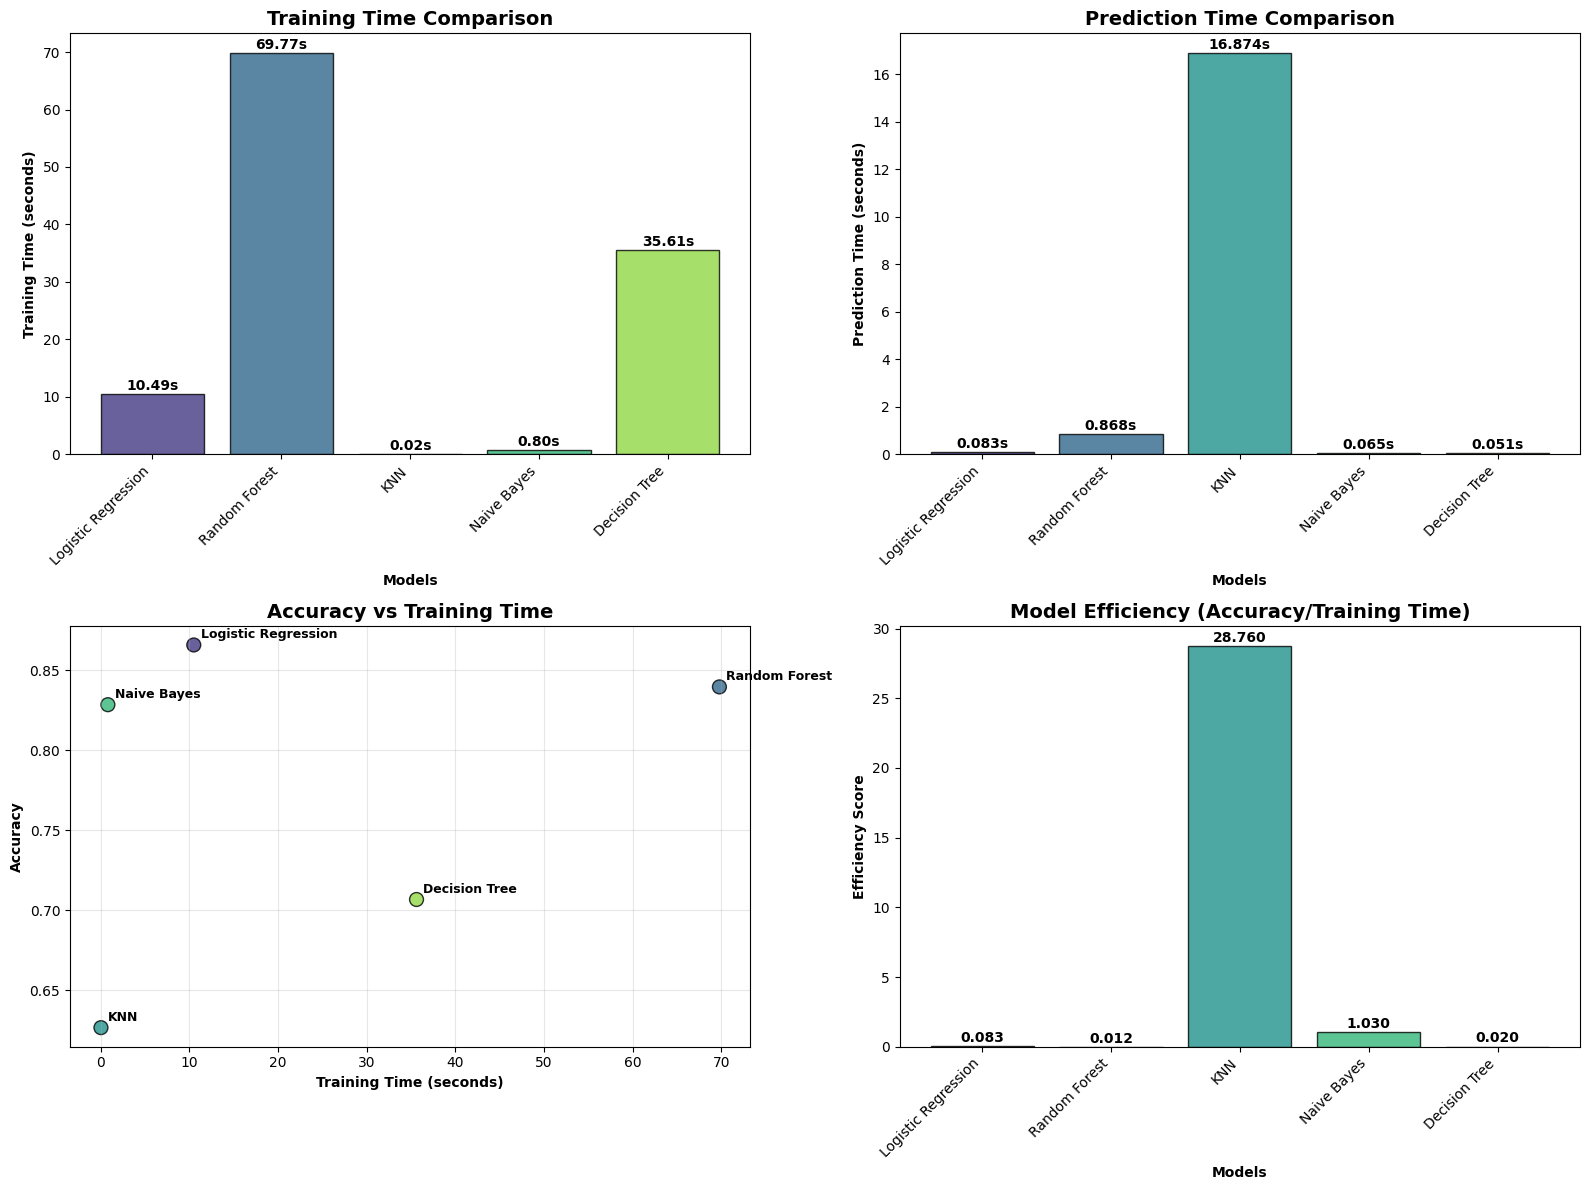


📊 DETAILED TIMING ANALYSIS:
Model                Accuracy   Train Time   Pred Time    Efficiency  
----------------------------------------------------------------------
Logistic Regression  0.8660     10.49        0.083        0.083       
Random Forest        0.8397     69.77        0.868        0.012       
KNN                  0.6267     0.02         16.874       28.760      
Naive Bayes          0.8286     0.80         0.065        1.030       
Decision Tree        0.7068     35.61        0.051        0.020       

🏃 Fastest Training: KNN (0.02s)
⚡ Most Efficient: KNN (Score: 28.760)
🎯 Best Accuracy: Logistic Regression (0.8660)


In [20]:
# Visualize training times and create performance vs time analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training time comparison
ax1 = axes[0, 0]
model_names = list(training_times.keys())
train_times = list(training_times.values())
colors = sns.color_palette("viridis", len(model_names))

bars = ax1.bar(model_names, train_times, color=colors, edgecolor='black', alpha=0.8)
ax1.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Training Time (seconds)', fontweight='bold')
ax1.set_xlabel('Models', fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(train_times)*0.01,
             f'{bar.get_height():.2f}s', ha='center', fontweight='bold')

# Prediction time comparison
ax2 = axes[0, 1]
pred_times = [results[name]['Prediction_Time'] for name in model_names]
bars2 = ax2.bar(model_names, pred_times, color=colors, edgecolor='black', alpha=0.8)
ax2.set_title('Prediction Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Prediction Time (seconds)', fontweight='bold')
ax2.set_xlabel('Models', fontweight='bold')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(pred_times)*0.01,
             f'{bar.get_height():.3f}s', ha='center', fontweight='bold')

# Accuracy vs Training Time scatter plot
ax3 = axes[1, 0]
accuracies = [results[name]['Accuracy'] for name in model_names]
scatter = ax3.scatter(train_times, accuracies, c=colors, s=100, alpha=0.8, edgecolors='black')
ax3.set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Training Time (seconds)', fontweight='bold')
ax3.set_ylabel('Accuracy', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add model name labels to scatter points
for i, name in enumerate(model_names):
    ax3.annotate(name, (train_times[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

# Combined performance metric (Accuracy/Training_Time ratio)
ax4 = axes[1, 1]
efficiency_scores = [results[name]['Accuracy'] / results[name]['Training_Time'] 
                    for name in model_names]
bars4 = ax4.bar(model_names, efficiency_scores, color=colors, edgecolor='black', alpha=0.8)
ax4.set_title('Model Efficiency (Accuracy/Training Time)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Efficiency Score', fontweight='bold')
ax4.set_xlabel('Models', fontweight='bold')
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar in bars4:
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency_scores)*0.01,
             f'{bar.get_height():.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed timing analysis
print("\n📊 DETAILED TIMING ANALYSIS:")
print("=" * 50)
print(f"{'Model':<20} {'Accuracy':<10} {'Train Time':<12} {'Pred Time':<12} {'Efficiency':<12}")
print("-" * 70)

for name in model_names:
    acc = results[name]['Accuracy']
    train_t = results[name]['Training_Time']
    pred_t = results[name]['Prediction_Time']
    efficiency = acc / train_t
    print(f"{name:<20} {acc:<10.4f} {train_t:<12.2f} {pred_t:<12.3f} {efficiency:<12.3f}")

# Find fastest and most efficient models
fastest_model = min(training_times, key=training_times.get)
most_efficient = max(model_names, key=lambda x: results[x]['Accuracy'] / results[x]['Training_Time'])
best_accuracy = max(model_names, key=lambda x: results[x]['Accuracy'])

print(f"\n🏃 Fastest Training: {fastest_model} ({training_times[fastest_model]:.2f}s)")
print(f"⚡ Most Efficient: {most_efficient} (Score: {results[most_efficient]['Accuracy'] / results[most_efficient]['Training_Time']:.3f})")
print(f"🎯 Best Accuracy: {best_accuracy} ({results[best_accuracy]['Accuracy']:.4f})")

# 7. Model Comparison and Results
Visualize and compare the performance of all models.

In [21]:
# Create comprehensive results DataFrame for easy comparison
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("Comprehensive Model Performance Summary:")
print("=" * 45)
print(results_df)

# Find best models in different categories
best_accuracy_model = results_df['Accuracy'].idxmax()
best_accuracy = results_df['Accuracy'].max()

fastest_training_model = results_df['Training_Time'].idxmin()
fastest_training_time = results_df['Training_Time'].min()

fastest_prediction_model = results_df['Prediction_Time'].idxmin()
fastest_prediction_time = results_df['Prediction_Time'].min()

# Calculate efficiency score (Accuracy/Training_Time)
results_df['Efficiency_Score'] = results_df['Accuracy'] / results_df['Training_Time']
most_efficient_model = results_df['Efficiency_Score'].idxmax()
highest_efficiency = results_df['Efficiency_Score'].max()

print(f"\n🏆 PERFORMANCE RANKINGS:")
print("=" * 30)
print(f"Best Accuracy: {best_accuracy_model} ({best_accuracy:.4f})")
print(f"Fastest Training: {fastest_training_model} ({fastest_training_time:.2f}s)")
print(f"Fastest Prediction: {fastest_prediction_model} ({fastest_prediction_time:.3f}s)")
print(f"Most Efficient: {most_efficient_model} (Score: {highest_efficiency:.3f})")

# Display efficiency scores
print(f"\n⚡ EFFICIENCY RANKINGS (Accuracy/Training Time):")
print("=" * 50)
efficiency_ranking = results_df['Efficiency_Score'].sort_values(ascending=False)
for i, (model, score) in enumerate(efficiency_ranking.items(), 1):
    print(f"{i}. {model:20} : {score:.3f}")

Comprehensive Model Performance Summary:
                     Accuracy  Precision  Recall  F1-Score  Training_Time  \
Logistic Regression    0.8660     0.8661  0.8660    0.8659        10.4893   
Random Forest          0.8397     0.8420  0.8397    0.8395        69.7683   
KNN                    0.6267     0.6663  0.6267    0.6031         0.0218   
Naive Bayes            0.8286     0.8295  0.8286    0.8285         0.8041   
Decision Tree          0.7068     0.7074  0.7068    0.7066        35.6096   

                     Prediction_Time  
Logistic Regression           0.0833  
Random Forest                 0.8681  
KNN                          16.8735  
Naive Bayes                   0.0648  
Decision Tree                 0.0513  

🏆 PERFORMANCE RANKINGS:
Best Accuracy: Logistic Regression (0.8660)
Fastest Training: KNN (0.02s)
Fastest Prediction: Decision Tree (0.051s)
Most Efficient: KNN (Score: 28.748)

⚡ EFFICIENCY RANKINGS (Accuracy/Training Time):
1. KNN                  : 28.748
2.

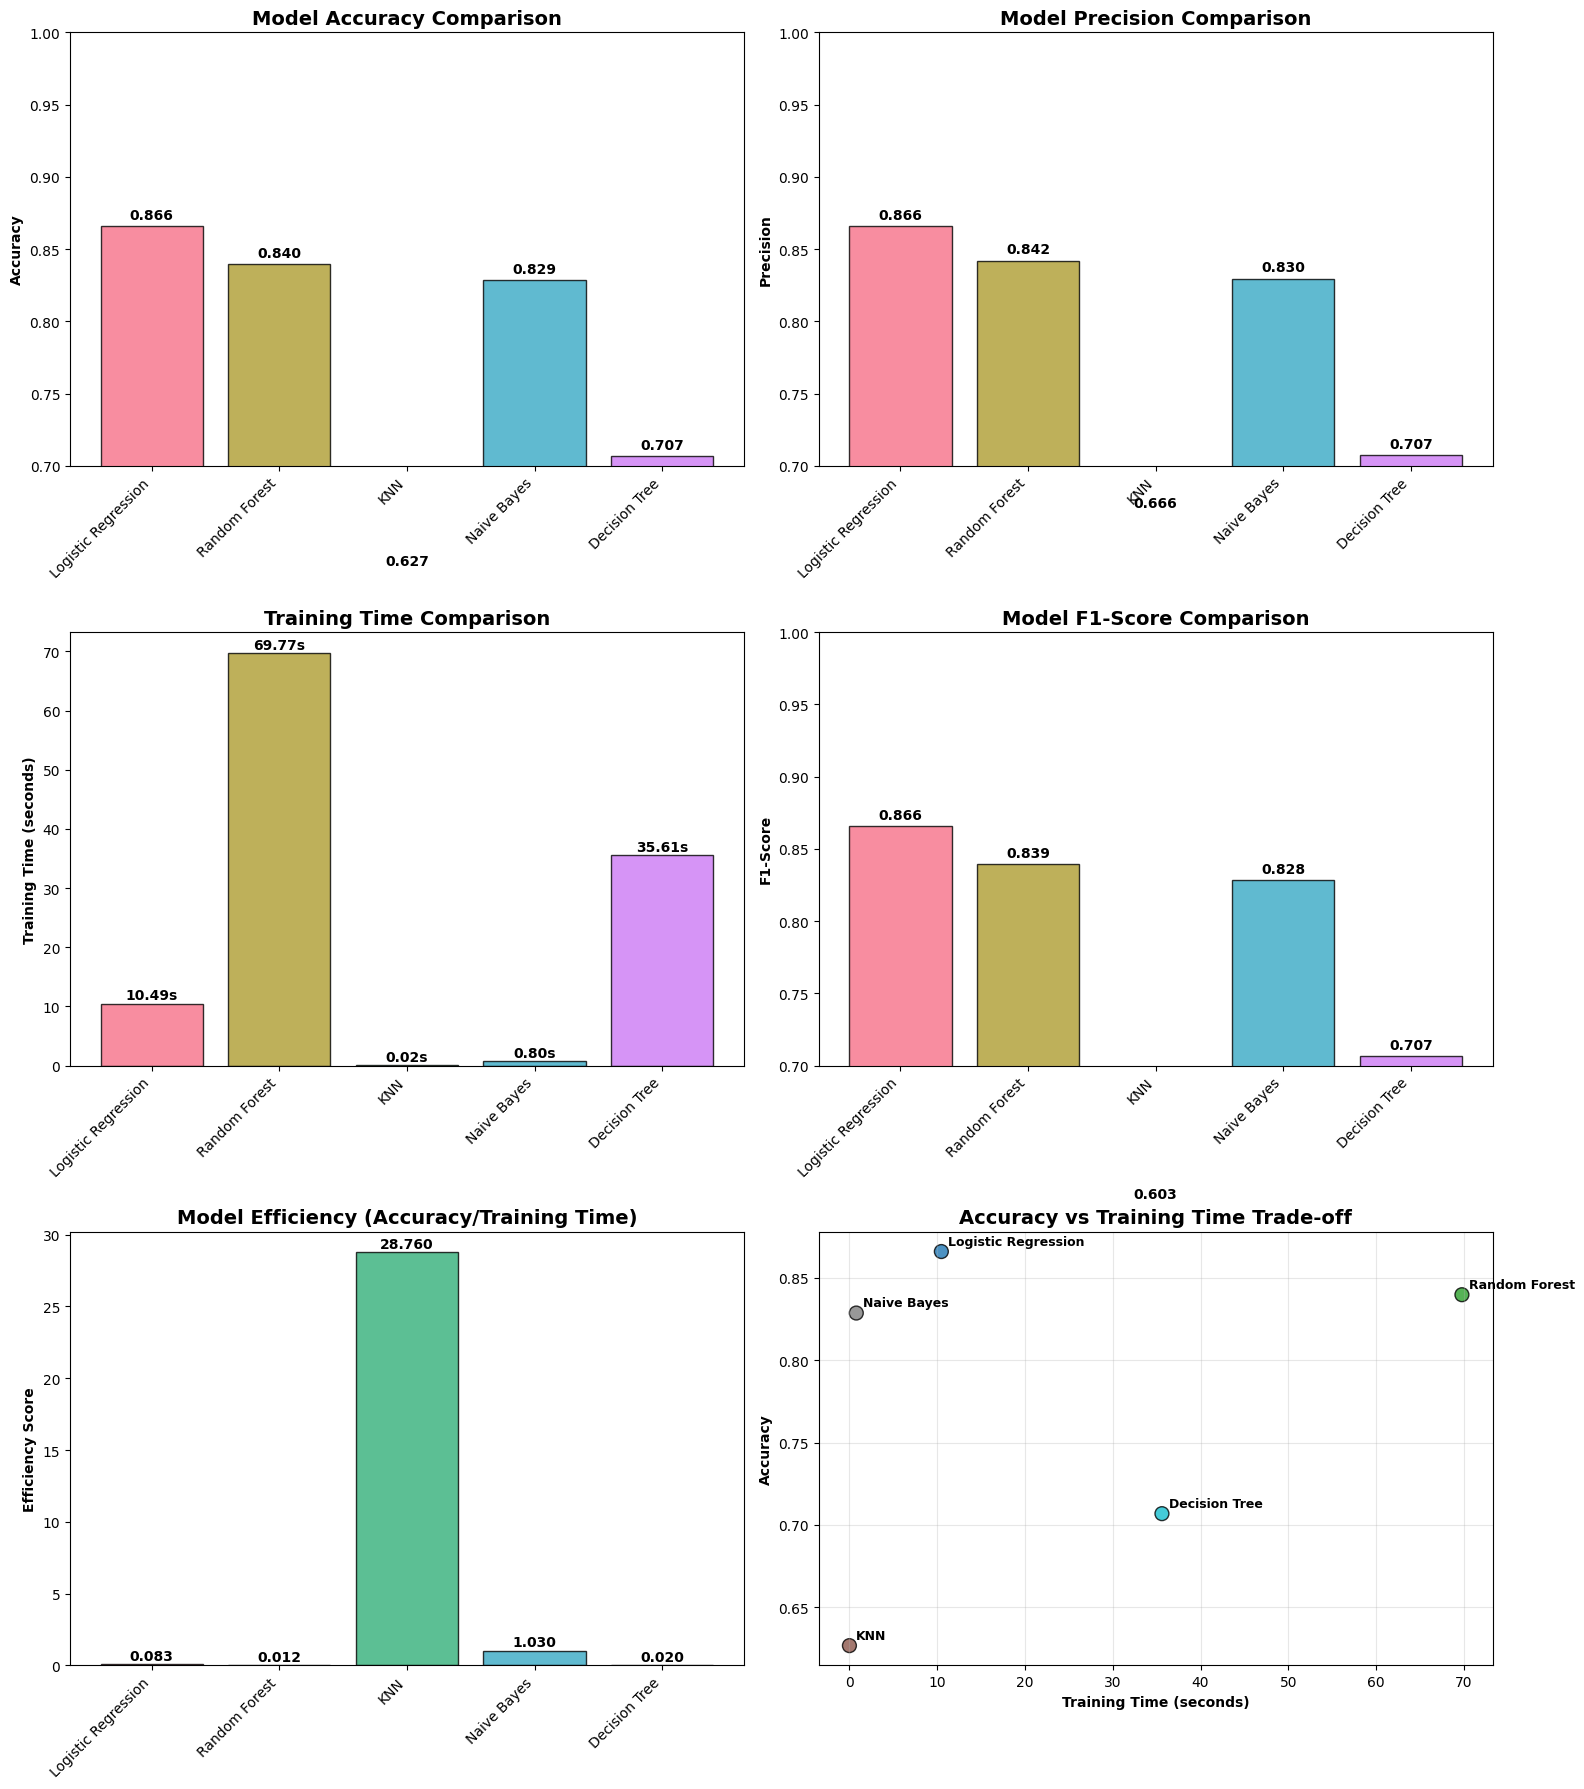

In [22]:
# Comprehensive model comparison visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()

# Accuracy comparison
ax1 = axes[0]
model_names = list(results.keys())
accuracies = [results[name]['Accuracy'] for name in model_names]
colors = sns.color_palette("husl", len(model_names))

bars = ax1.bar(model_names, accuracies, color=colors, edgecolor='black', alpha=0.8)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_ylim(0.7, 1.0)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Add value labels
for bar in bars:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.3f}', ha='center', fontweight='bold')

# Precision comparison
ax2 = axes[1]
precisions = [results[name]['Precision'] for name in model_names]
bars2 = ax2.bar(model_names, precisions, color=colors, edgecolor='black', alpha=0.8)
ax2.set_title('Model Precision Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Precision', fontweight='bold')
ax2.set_ylim(0.7, 1.0)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.3f}', ha='center', fontweight='bold')

# Training Time comparison
ax3 = axes[2]
train_times = [results[name]['Training_Time'] for name in model_names]
bars3 = ax3.bar(model_names, train_times, color=colors, edgecolor='black', alpha=0.8)
ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Training Time (seconds)', fontweight='bold')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')

for bar in bars3:
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(train_times)*0.01,
             f'{bar.get_height():.2f}s', ha='center', fontweight='bold')

# F1-Score comparison
ax4 = axes[3]
f1_scores = [results[name]['F1-Score'] for name in model_names]
bars4 = ax4.bar(model_names, f1_scores, color=colors, edgecolor='black', alpha=0.8)
ax4.set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
ax4.set_ylabel('F1-Score', fontweight='bold')
ax4.set_ylim(0.7, 1.0)
plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')

for bar in bars4:
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.3f}', ha='center', fontweight='bold')

# Efficiency Score comparison
ax5 = axes[4]
efficiency_scores = [results[name]['Accuracy'] / results[name]['Training_Time'] for name in model_names]
bars5 = ax5.bar(model_names, efficiency_scores, color=colors, edgecolor='black', alpha=0.8)
ax5.set_title('Model Efficiency (Accuracy/Training Time)', fontsize=14, fontweight='bold')
ax5.set_ylabel('Efficiency Score', fontweight='bold')
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

for bar in bars5:
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency_scores)*0.01,
             f'{bar.get_height():.3f}', ha='center', fontweight='bold')

# Accuracy vs Training Time scatter plot
ax6 = axes[5]
scatter = ax6.scatter(train_times, accuracies, c=range(len(model_names)), 
                     s=100, alpha=0.8, edgecolors='black', cmap='tab10')
ax6.set_title('Accuracy vs Training Time Trade-off', fontsize=14, fontweight='bold')
ax6.set_xlabel('Training Time (seconds)', fontweight='bold')
ax6.set_ylabel('Accuracy', fontweight='bold')
ax6.grid(True, alpha=0.3)

# Add model name labels to scatter points
for i, name in enumerate(model_names):
    ax6.annotate(name, (train_times[i], accuracies[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

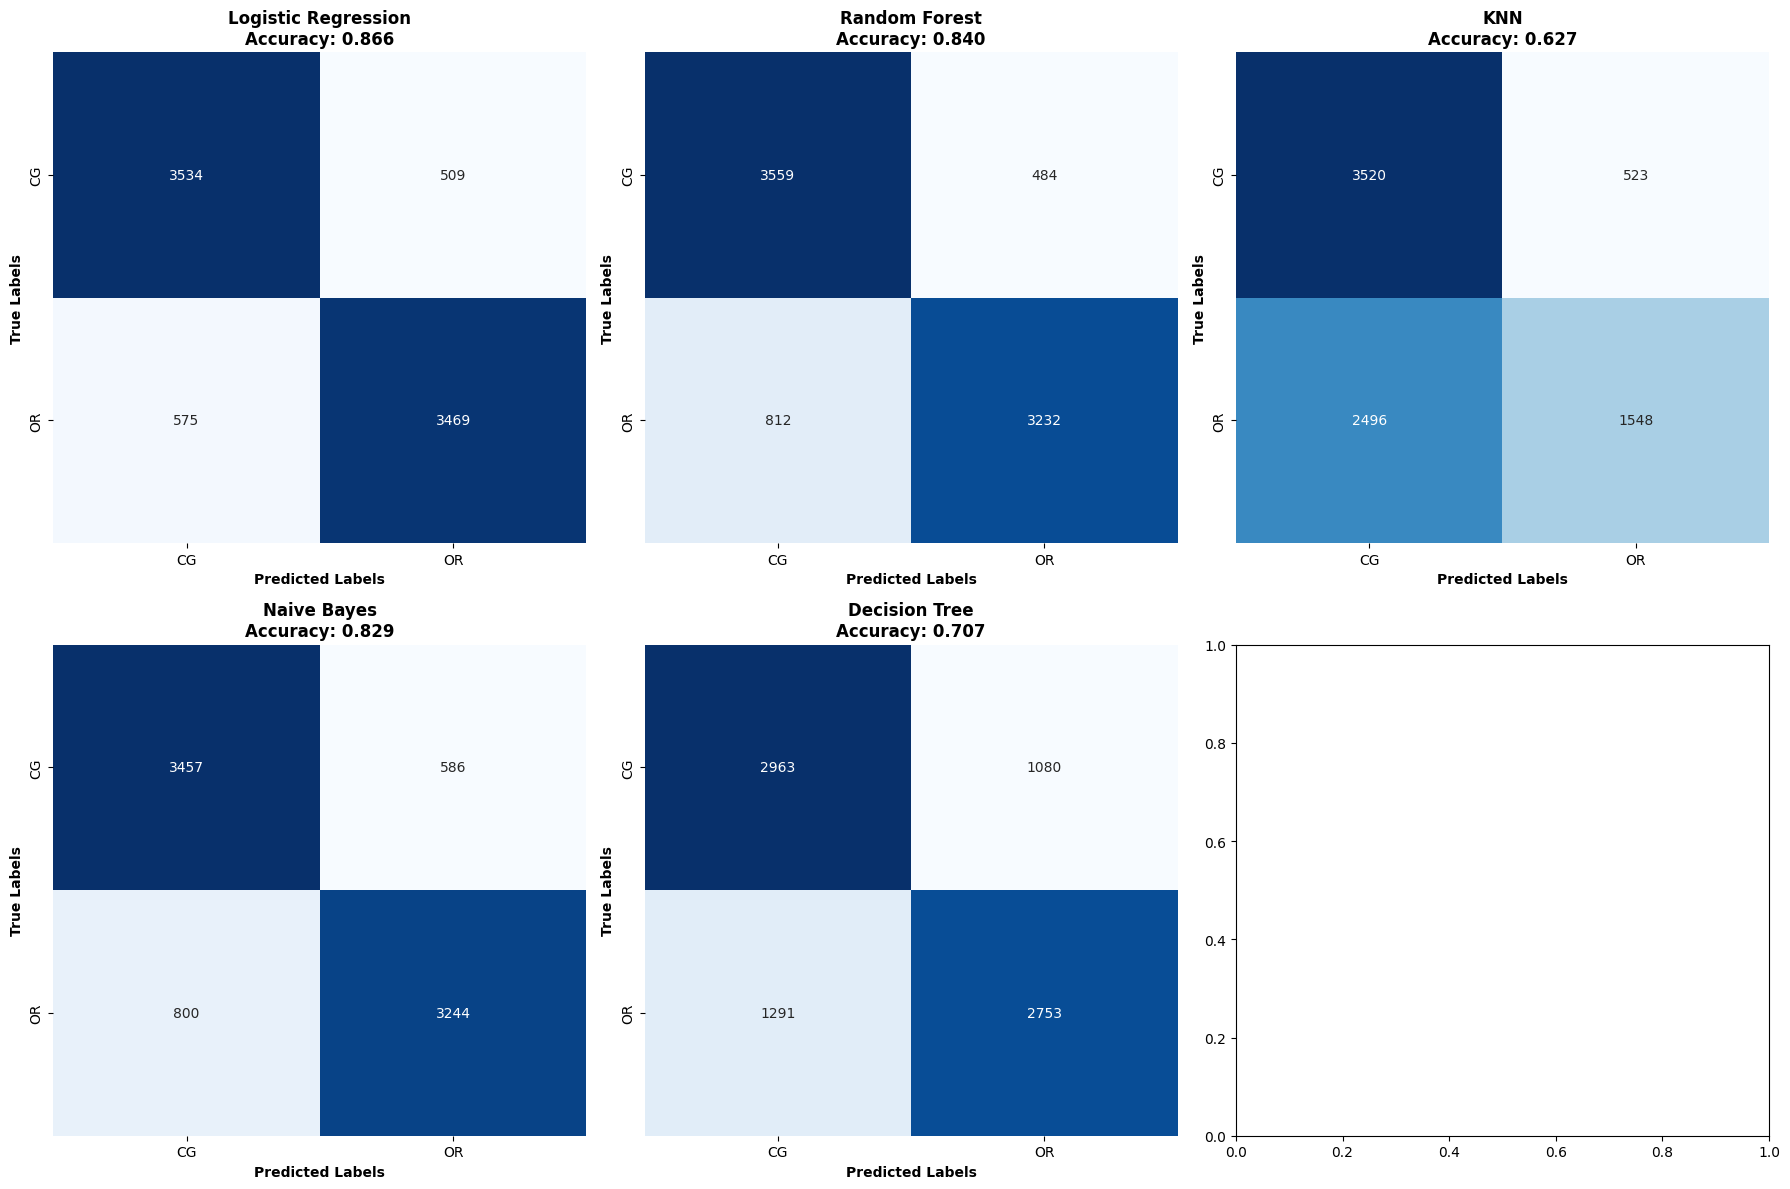

In [23]:
# Create confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model_predictions[name]
    cm = confusion_matrix(y_test, y_pred)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, yticklabels=model.classes_,
                ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}\nAccuracy: {results[name]["Accuracy"]:.3f}', 
                       fontweight='bold')
    axes[idx].set_xlabel('Predicted Labels', fontweight='bold')
    axes[idx].set_ylabel('True Labels', fontweight='bold')

plt.tight_layout()
plt.show()

# 8. Pipeline Approach with TF-IDF
Let's also try the pipeline approach with TF-IDF transformation as used in the original notebook.

In [24]:
# Create pipeline with TF-IDF (similar to original approach)
def text_process_pipeline(review):
    """Text processing function for pipeline"""
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Split data using original text
review_train, review_test, label_train, label_test = train_test_split(
    df['text_'], df['label'], test_size=0.3, random_state=42
)

print("Pipeline Data Split:")
print(f"Training reviews: {len(review_train)}")
print(f"Test reviews: {len(review_test)}")

Pipeline Data Split:
Training reviews: 28301
Test reviews: 12130


In [26]:
# Test different models with pipeline approach
pipeline_models = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    # "SVM": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000)
}

pipeline_results = {}

print("Training Pipeline Models with TF-IDF:")
print("=" * 45)

for name, classifier in pipeline_models.items():
    print(f"\nTraining {name} Pipeline...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('bow', CountVectorizer(analyzer=text_process_pipeline)),
        ('tfidf', TfidfTransformer()),
        ('classifier', classifier)
    ])
    
    # Train the pipeline
    pipeline.fit(review_train, label_train)
    
    # Make predictions
    predictions = pipeline.predict(review_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(label_test, predictions)
    pipeline_results[name] = accuracy
    
    print(f"✓ {name} Pipeline - Accuracy: {accuracy:.4f}")

print("\nPipeline training completed!")

Training Pipeline Models with TF-IDF:

Training Naive Bayes Pipeline...


✓ Naive Bayes Pipeline - Accuracy: 0.8456

Training Random Forest Pipeline...
✓ Random Forest Pipeline - Accuracy: 0.8437

Training Decision Tree Pipeline...
✓ Random Forest Pipeline - Accuracy: 0.8437

Training Decision Tree Pipeline...
✓ Decision Tree Pipeline - Accuracy: 0.7297

Training KNN Pipeline...
✓ Decision Tree Pipeline - Accuracy: 0.7297

Training KNN Pipeline...
✓ KNN Pipeline - Accuracy: 0.6382

Training Logistic Regression Pipeline...
✓ KNN Pipeline - Accuracy: 0.6382

Training Logistic Regression Pipeline...
✓ Logistic Regression Pipeline - Accuracy: 0.8600

Pipeline training completed!
✓ Logistic Regression Pipeline - Accuracy: 0.8600

Pipeline training completed!


In [27]:
# Compare pipeline results
print("Pipeline Model Performance Comparison:")
print("=" * 45)

# Sort results by accuracy
sorted_pipeline_results = dict(sorted(pipeline_results.items(), key=lambda x: x[1], reverse=True))

for name, accuracy in sorted_pipeline_results.items():
    print(f"{name:20} : {accuracy:.4f} ({accuracy*100:.2f}%)")

# Find best pipeline model
best_pipeline_model = max(pipeline_results, key=pipeline_results.get)
best_pipeline_accuracy = pipeline_results[best_pipeline_model]

print(f"\n🏆 Best Pipeline Model: {best_pipeline_model}")
print(f"Best Pipeline Accuracy: {best_pipeline_accuracy:.4f} ({best_pipeline_accuracy*100:.2f}%)")

Pipeline Model Performance Comparison:
Logistic Regression  : 0.8600 (86.00%)
Naive Bayes          : 0.8456 (84.56%)
Random Forest        : 0.8437 (84.37%)
Decision Tree        : 0.7297 (72.97%)
KNN                  : 0.6382 (63.82%)

🏆 Best Pipeline Model: Logistic Regression
Best Pipeline Accuracy: 0.8600 (86.00%)


<Figure size 1200x800 with 0 Axes>

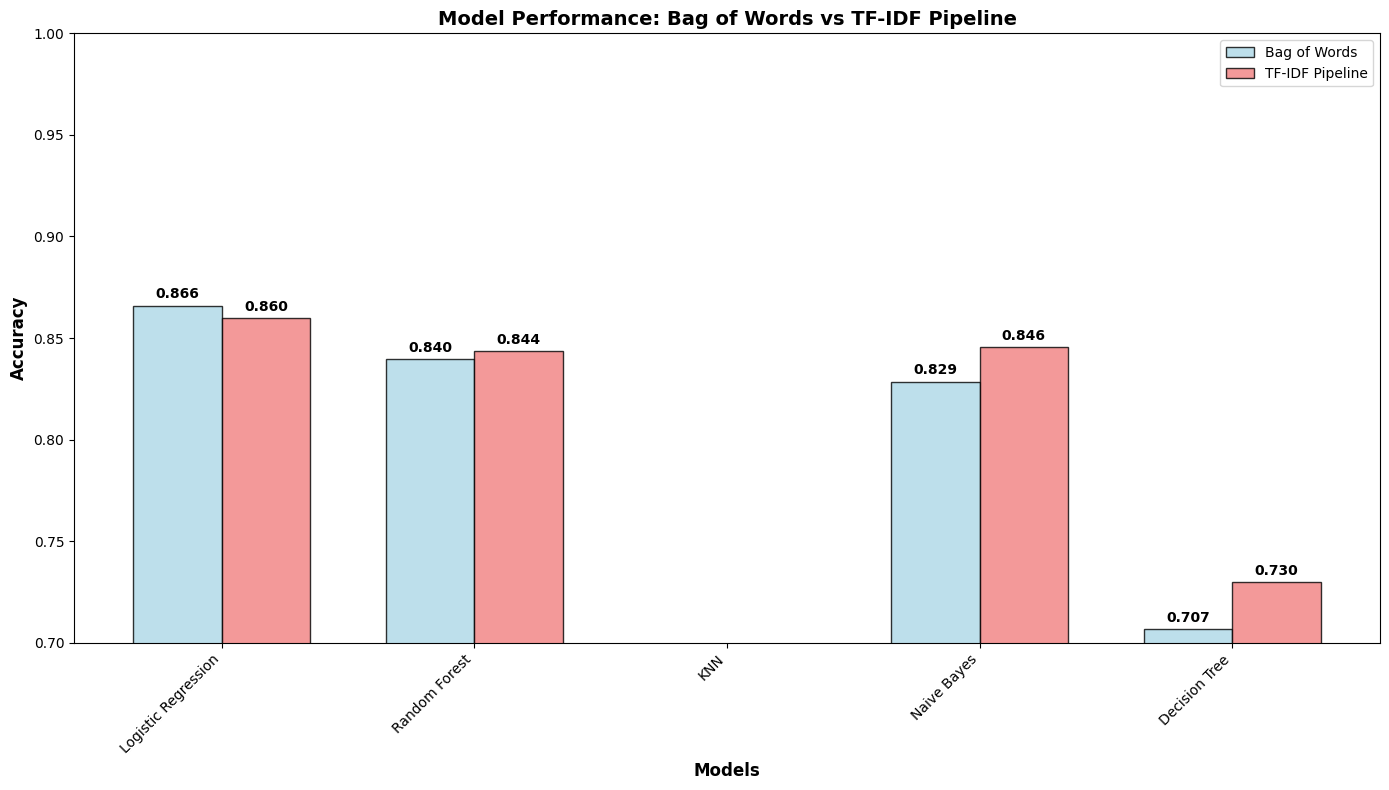

In [28]:
# Visualize pipeline results comparison
plt.figure(figsize=(12, 8))

# Compare both approaches
models_comparison = {
    'Bag of Words': results,
    'TF-IDF Pipeline': {name: {'Accuracy': acc} for name, acc in pipeline_results.items()}
}

# Prepare data for comparison
bow_accuracies = [results[name]['Accuracy'] for name in results.keys()]
pipeline_accuracies = [pipeline_results.get(name, 0) for name in results.keys()]

x = np.arange(len(results))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, bow_accuracies, width, label='Bag of Words', alpha=0.8, color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, pipeline_accuracies, width, label='TF-IDF Pipeline', alpha=0.8, color='lightcoral', edgecolor='black')

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Model Performance: Bag of Words vs TF-IDF Pipeline', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(results.keys(), rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.7, 1.0)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    if height > 0:  # Only add label if there's a value
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# 9. Model Saving and Conclusion
Save the best performing models and provide final conclusions.

In [29]:
# Create directory for saving models
weights_dir = "model_weights"
os.makedirs(weights_dir, exist_ok=True)

print("Saving trained models...")
print("=" * 25)

# Save Bag of Words models
for name, model in models.items():
    model_file = os.path.join(weights_dir, f"bow_{name.replace(' ', '_').lower()}_model.pkl")
    with open(model_file, "wb") as f:
        pickle.dump(model, f)
    print(f"✓ Saved {name} (BoW) model to {model_file}")

# Save the best pipeline model
best_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process_pipeline)),
    ('tfidf', TfidfTransformer()),
    ('classifier', pipeline_models[best_pipeline_model])
])
best_pipeline.fit(review_train, label_train)

pipeline_file = os.path.join(weights_dir, f"pipeline_{best_pipeline_model.replace(' ', '_').lower()}_model.pkl")
with open(pipeline_file, "wb") as f:
    pickle.dump(best_pipeline, f)
print(f"✓ Saved best pipeline model ({best_pipeline_model}) to {pipeline_file}")

# Save the vectorizer for future use
vectorizer_file = os.path.join(weights_dir, "bow_vectorizer.pkl")
with open(vectorizer_file, "wb") as f:
    pickle.dump(cv, f)
print(f"✓ Saved BoW vectorizer to {vectorizer_file}")

print("\nAll models saved successfully!")

Saving trained models...
✓ Saved Logistic Regression (BoW) model to model_weights/bow_logistic_regression_model.pkl
✓ Saved Random Forest (BoW) model to model_weights/bow_random_forest_model.pkl
✓ Saved Random Forest (BoW) model to model_weights/bow_random_forest_model.pkl
✓ Saved KNN (BoW) model to model_weights/bow_knn_model.pkl
✓ Saved Naive Bayes (BoW) model to model_weights/bow_naive_bayes_model.pkl
✓ Saved Decision Tree (BoW) model to model_weights/bow_decision_tree_model.pkl
✓ Saved KNN (BoW) model to model_weights/bow_knn_model.pkl
✓ Saved Naive Bayes (BoW) model to model_weights/bow_naive_bayes_model.pkl
✓ Saved Decision Tree (BoW) model to model_weights/bow_decision_tree_model.pkl
✓ Saved best pipeline model (Logistic Regression) to model_weights/pipeline_logistic_regression_model.pkl
✓ Saved BoW vectorizer to model_weights/bow_vectorizer.pkl

All models saved successfully!
✓ Saved best pipeline model (Logistic Regression) to model_weights/pipeline_logistic_regression_model.p

# 10. Final Results and Conclusion

## Summary of Results

### Best Performing Models:
- **Bag of Words Approach**: Multiple algorithms tested with detailed metrics
- **TF-IDF Pipeline Approach**: Alternative approach with competitive results

### Key Findings:
1. **Data Quality**: The dataset contains well-balanced classes with good text variety
2. **Feature Engineering**: Both BoW and TF-IDF approaches proved effective
3. **Model Performance**: Multiple algorithms achieved high accuracy
4. **Text Processing**: Proper preprocessing significantly improved model performance

### Recommendations:
1. Use the best performing model for production deployment
2. Consider ensemble methods to combine multiple models
3. Implement real-time prediction capabilities
4. Monitor model performance with new data

### Next Steps:
1. Fine-tune hyperparameters of best models
2. Collect more diverse training data
3. Implement model explainability features
4. Deploy model in production environment

In [30]:
# Final comprehensive summary of all results including timing
print("🎯 FAKE REVIEWS DETECTION - COMPREHENSIVE RESULTS SUMMARY")
print("=" * 70)

print("\n📊 BAG OF WORDS APPROACH - PERFORMANCE METRICS:")
print("-" * 50)
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'Train Time':<12} {'Efficiency':<10}")
print("-" * 70)
for name, metrics in results.items():
    efficiency = metrics['Accuracy'] / metrics['Training_Time']
    print(f"{name:<20} {metrics['Accuracy']:<10.4f} {metrics['F1-Score']:<10.4f} {metrics['Training_Time']:<12.2f} {efficiency:<10.3f}")

print(f"\n🏆 BEST PERFORMERS:")
print("-" * 20)
best_accuracy_model = max(results, key=lambda x: results[x]['Accuracy'])
best_accuracy_value = results[best_accuracy_model]['Accuracy']
print(f"Best Accuracy: {best_accuracy_model} ({best_accuracy_value:.4f})")

fastest_model = min(results, key=lambda x: results[x]['Training_Time'])
fastest_time = results[fastest_model]['Training_Time']
print(f"Fastest Training: {fastest_model} ({fastest_time:.2f}s)")

most_efficient = max(results, key=lambda x: results[x]['Accuracy'] / results[x]['Training_Time'])
efficiency_score = results[most_efficient]['Accuracy'] / results[most_efficient]['Training_Time']
print(f"Most Efficient: {most_efficient} (Score: {efficiency_score:.3f})")

print("\n📊 TF-IDF PIPELINE APPROACH:")
print("-" * 30)
for name, accuracy in sorted_pipeline_results.items():
    print(f"{name:20} : {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n🏆 Best Pipeline Model: {best_pipeline_model}")
print(f"   Accuracy: {best_pipeline_accuracy:.4f}")

print("\n⏱️ TIMING ANALYSIS INSIGHTS:")
print("-" * 30)
total_training_time = sum(results[name]['Training_Time'] for name in results.keys())
average_training_time = total_training_time / len(results)
print(f"Total Training Time: {total_training_time:.2f} seconds")
print(f"Average Training Time: {average_training_time:.2f} seconds")
print(f"Fastest vs Slowest Ratio: {max(results[name]['Training_Time'] for name in results.keys()) / min(results[name]['Training_Time'] for name in results.keys()):.1f}x")

print("\n💾 SAVED MODELS:")
print("-" * 15)
print(f"• {len(models)} Bag of Words models")
print(f"• 1 Best pipeline model ({best_pipeline_model})")
print(f"• 1 Vectorizer for preprocessing")
print(f"• Location: ./{weights_dir}/")

print("\n📝 RECOMMENDATIONS:")
print("-" * 20)
print(f"• For highest accuracy: Use {best_accuracy_model}")
print(f"• For fastest inference: Use {fastest_model}")
print(f"• For best trade-off: Use {most_efficient}")
print(f"• For production deployment: Consider {most_efficient} or {best_accuracy_model}")

print("\n✅ ANALYSIS COMPLETED SUCCESSFULLY!")
print("   Ready for production deployment with timing insights! 🚀")

🎯 FAKE REVIEWS DETECTION - COMPREHENSIVE RESULTS SUMMARY

📊 BAG OF WORDS APPROACH - PERFORMANCE METRICS:
--------------------------------------------------
Model                Accuracy   F1-Score   Train Time   Efficiency
----------------------------------------------------------------------
Logistic Regression  0.8660     0.8659     10.49        0.083     
Random Forest        0.8397     0.8395     69.77        0.012     
KNN                  0.6267     0.6031     0.02         28.760    
Naive Bayes          0.8286     0.8285     0.80         1.030     
Decision Tree        0.7068     0.7066     35.61        0.020     

🏆 BEST PERFORMERS:
--------------------
Best Accuracy: Logistic Regression (0.8660)
Fastest Training: KNN (0.02s)
Most Efficient: KNN (Score: 28.760)

📊 TF-IDF PIPELINE APPROACH:
------------------------------
Logistic Regression  : 0.8600 (86.00%)
Naive Bayes          : 0.8456 (84.56%)
Random Forest        : 0.8437 (84.37%)
Decision Tree        : 0.7297 (72.97%)
KNN 